In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('dataset/gold_label_dataset.pkl', 'rb') as file:
    df = pd.compat.pickle_compat.load(file) 

In [3]:
emotions = df.columns[df.columns.str.startswith("M_")].values.tolist()
emotions = [e[2:].lower() for e in emotions]
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'sadness',
 'something else',
 'surprise',
 'trust']

## Analysis on distribution of labels

In [4]:
cols = df.columns[df.columns.str.startswith("label_")].tolist()
freq_counts = {e: dict.fromkeys(emotions, 0) for e in cols}
for index, row in df.iterrows():
    for column in cols:
        for elem in row[column]:
            freq_counts[column][elem] += 1

Some of the emotions are overrepresented, specifically "joy" and "something else". On the other hand, "fear" and "trust" are somewhat underrepresented. This is true for all types of labels, as the distribution is mostly the same across them, with some minor differences between multimodal and text only labels. In general the disparity in number of entries is less extreme in the text only labels. <br>
<!-- TODO: find better phrasing -->
The presence of a large number of entries with the "something else" label suggests that the emotions used as labels are not sufficient to express the range of emotions contained in the dataset.

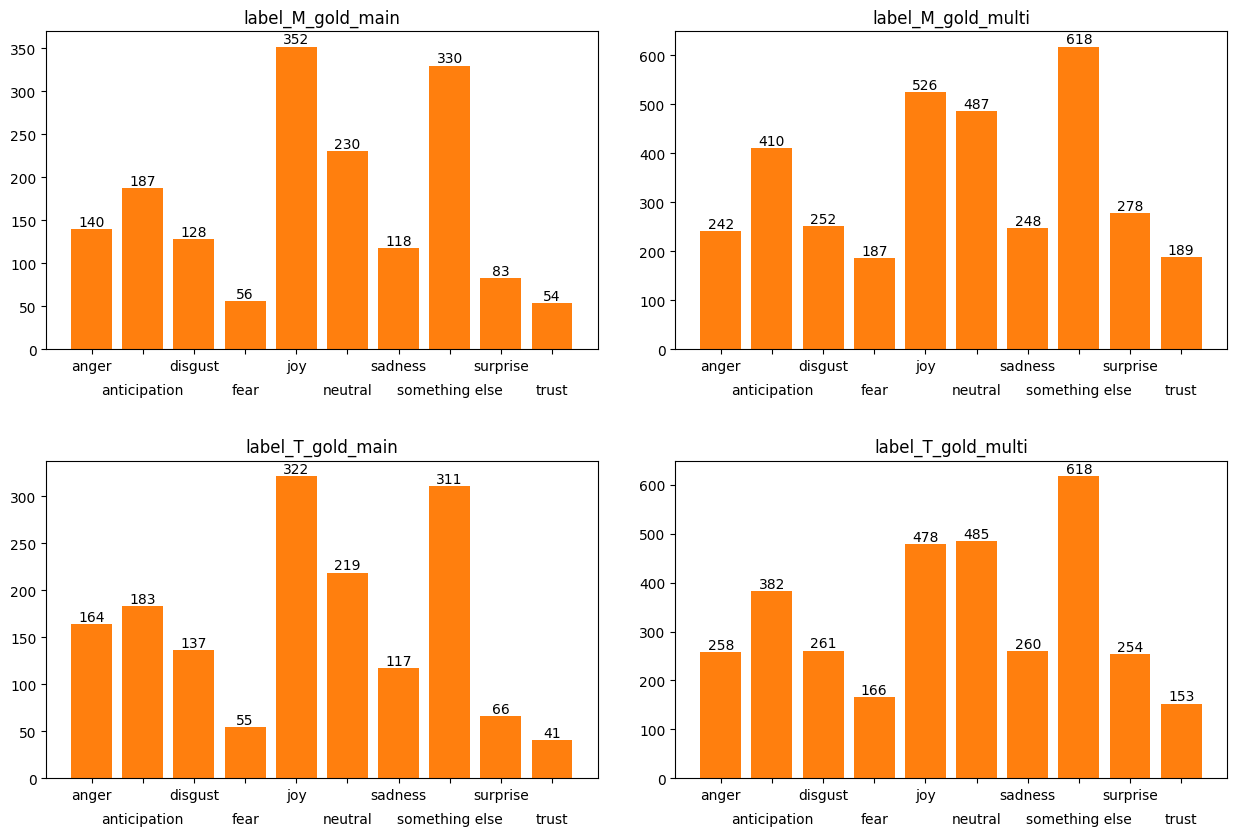

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (13, 9))
for i, ax in enumerate(axs.reshape(-1)):
    ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.set_title(cols[i])
    bars = ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.bar_label(bars, freq_counts[cols[i]].values())
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        label.set_y(label.get_position()[1] - (i % 2) * 0.075)
fig.tight_layout(pad=3)
plt.show()

There are also 34 entries which have an empty main gold multimodal label (which means none of the emotions have a score of at least 2). For the text only label there are 11 empy entries. These will need to be handled in some way. A possible solution might be to take the labels considering scores of at least 1.

In [6]:
df.loc[df["label_M_gold_main"].apply(len)==0].shape

(34, 34)

Double check on score columns as well instead of list with labels. The number of samples where no emotion has a score greater than or equal to 2 is the same in both cases

In [7]:
# mask checking for scores greater than or equal to 2
mask = df[[f"M_{x.capitalize()}" for x in emotions]].ge(2)

# check if on a row there is at least one emotion with score greater than or equal to 2 and print number of rows where it is true or false
mask.any(axis=1).value_counts()

True     866
False     34
Name: count, dtype: int64

Number of samples to remove considering each tweet-image pair as a separate sample

In [8]:
sum = 0
for i, row in df[~mask.any(axis=1)].iterrows():
    sum += row["img_count"]
sum

46

In [9]:
df.loc[df["label_T_gold_main"].apply(len)==0].shape

(11, 34)

In [10]:
# mask checking for scores greater than or equal to 2
mask = df[[f"T_{x.capitalize()}" for x in emotions]].ge(2)

# check if on a row there is at least one emotion with score greater than or equal to 2 and print number of rows where it is true or false
mask.any(axis=1).value_counts()

True     889
False     11
Name: count, dtype: int64

Number of samples to remove considering each tweet-image pair as a separate sample

In [11]:
sum = 0
for i, row in df[~mask.any(axis=1)].iterrows():
    sum += row["img_count"]
sum

18

Most samples have multiple labels, even when considering a threshold of 2. Some emotions appear by themselves much less often than others. The ones that appear alone most often are joy, neutral and something else.

In [12]:
cols = df.columns[df.columns.str.startswith("label_")].tolist()
freq_counts = {e: dict.fromkeys(emotions, 0) for e in cols}

for e in emotions:
    for column in cols:
        freq_counts[column][e] = df[(df[column].apply(lambda x: e in x)) & (df[column].apply(len)==1)].shape[0]

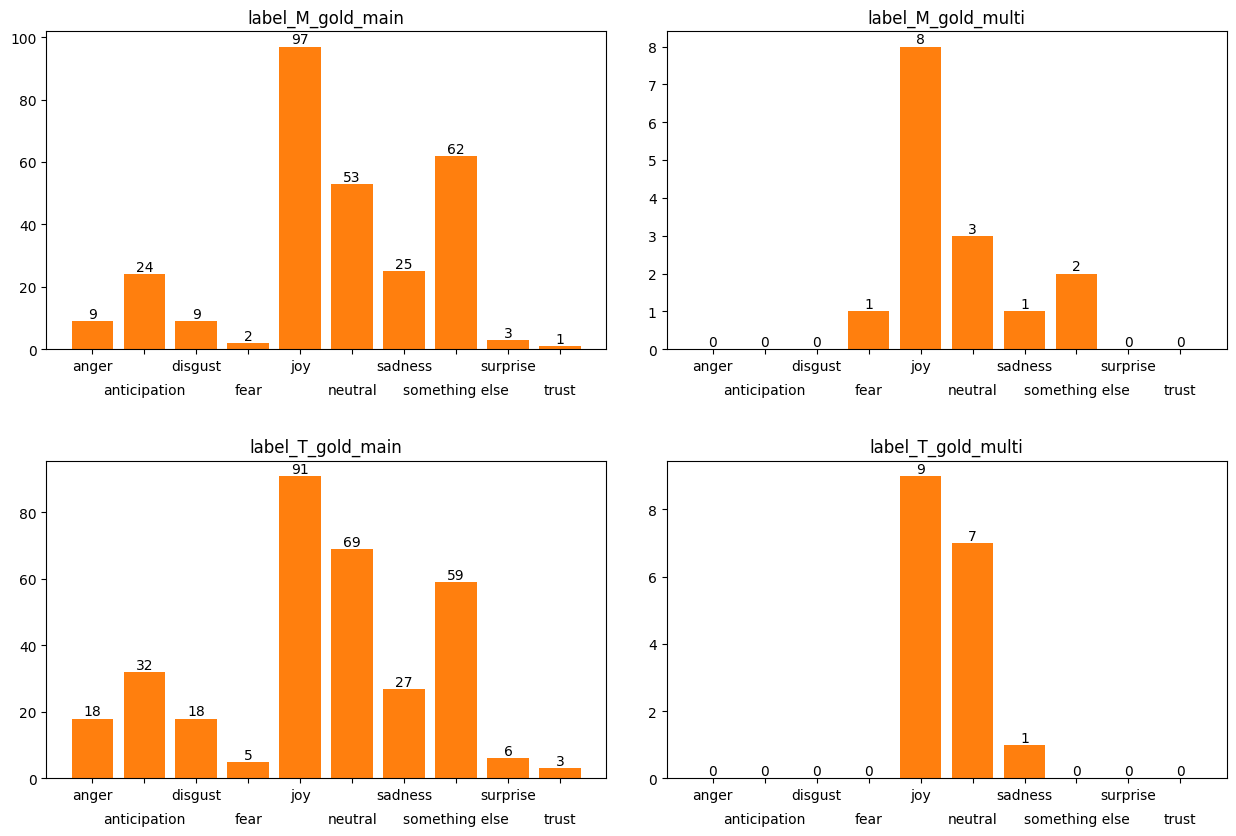

In [13]:
fig, axs = plt.subplots(2, 2, figsize = (13, 9))
for i, ax in enumerate(axs.reshape(-1)):
    ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.set_title(cols[i])
    bars = ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.bar_label(bars, freq_counts[cols[i]].values())
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        label.set_y(label.get_position()[1] - (i % 2) * 0.075)
fig.tight_layout(pad=3)
plt.show()

Plotting distribution of number of votes for each emotion.

In [14]:
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display, clear_output

options = df.columns[df.columns.str.startswith("M_")].values.tolist()
options = [x[2:] for x in options]

drop_down = widgets.Dropdown(options = options,
                             value = "Joy",
                             description = "Emotion",
                             disabled = False)

def dropdown_handler(emotion):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,6))

    values = df[f"M_{emotion}"].value_counts()

    bars = axes[0].bar(values.index.values, values.values)
    axes[0].bar_label(bars, values.values)
    axes[0].set_title(f"Score distribution for {emotion} (Multimodal)")

    values = df[f"T_{emotion}"].value_counts()

    bars = axes[1].bar(values.index.values, values.values)
    axes[1].bar_label(bars, values.values)
    axes[1].set_title(f"Score distribution for {emotion} (Text only)")
    
    plt.show()
    plt.close()

w = interactive(dropdown_handler, emotion = drop_down)
display(w)

interactive(children=(Dropdown(description='Emotion', index=4, options=('Anger', 'Anticipation', 'Disgust', 'F…

In [15]:
df[df.columns[df.columns.str.startswith("M_") | df.columns.str.startswith("T_")].values.tolist()].mean()

M_Anger             0.576667
M_Anticipation      0.818889
M_Disgust           0.537778
M_Fear              0.303333
M_Joy               1.518889
M_Neutral           0.940000
M_Sadness           0.542222
M_Something else    1.224444
M_Surprise          0.433333
M_Trust             0.282222
T_Anger             0.646667
T_Anticipation      0.772222
T_Disgust           0.562222
T_Fear              0.266667
T_Joy               1.385556
T_Neutral           0.945556
T_Sadness           0.568889
T_Something else    1.202222
T_Surprise          0.397778
T_Trust             0.223333
dtype: float64

Plot of the number of images for each emotion where the sample only has that emotion

In [16]:
drop_down = widgets.Dropdown(options = emotions,
                             description = "Emotion",
                             value = "something else",
                             disabled = False)

def dropdown_handler(emotion):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,6))

    values = df.loc[df["label_M_gold_main"].apply(lambda x : emotion in x and len(x)==1)]["img_count"].value_counts()

    bars = axes[0].bar(values.index.values, values.values)
    axes[0].bar_label(bars, values.values)
    axes[0].set_title(f"Number of images for {emotion} only samples (Multimodal)")

    values = df.loc[df["label_T_gold_main"].apply(lambda x : emotion in x and len(x)==1)]["img_count"].value_counts()

    bars = axes[1].bar(values.index.values, values.values)
    axes[1].bar_label(bars, values.values)
    axes[1].set_title(f"Number of images for {emotion} only samples (Text only)")

    
    plt.show()
    plt.close()


w = interactive(dropdown_handler, emotion = drop_down)
display(w)

interactive(children=(Dropdown(description='Emotion', index=7, options=('anger', 'anticipation', 'disgust', 'f…

Plot of the number of images for each emotion where the sample has that emotion as one of its labels

In [17]:
drop_down = widgets.Dropdown(options = emotions,
                             description = "Emotion",
                             value = "something else",
                             disabled = False)

def dropdown_handler(emotion):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,6))

    values = df.loc[df["label_M_gold_main"].apply(lambda x : emotion in x)]["img_count"].value_counts()

    bars = axes[0].bar(values.index.values, values.values)
    axes[0].bar_label(bars, values.values)
    axes[0].set_title(f"Number of images for {emotion} samples (Multimodal)")

    values = df.loc[df["label_T_gold_main"].apply(lambda x : emotion in x)]["img_count"].value_counts()

    bars = axes[1].bar(values.index.values, values.values)
    axes[1].bar_label(bars, values.values)
    axes[1].set_title(f"Number of images for {emotion} samples (Text only)")

    
    plt.show()
    plt.close()


w = interactive(dropdown_handler, emotion = drop_down)
display(w)

interactive(children=(Dropdown(description='Emotion', index=7, options=('anger', 'anticipation', 'disgust', 'f…

Number of samples to be dropped:
<ul>
    <li> 96 for multimodal labels (138 considering a sample for each image)</li>
    <li> 70 for txt only labels (95 considering a sample for each image)</li>
</ul>

In [18]:
empty_label_samples = df.loc[df["label_M_gold_main"].apply(len)==0].shape[0]
print(empty_label_samples + freq_counts["label_M_gold_main"]["something else"])

96


In [19]:
label = "label_M_gold_main"
tot = 0
for i, row in df.iterrows():
    if len(row[label])==0 or ("something else" in row[label] and len(row[label])==1):
        tot += row["img_count"]
print(tot)

138


In [20]:
empty_label_samples = df.loc[df["label_T_gold_main"].apply(len)==0].shape[0]
print(empty_label_samples + freq_counts["label_T_gold_main"]["something else"])

70


In [21]:
label = "label_T_gold_main"
tot = 0
for i, row in df.iterrows():
    if len(row[label])==0 or ("something else" in row[label] and len(row[label])==1):
        tot += row["img_count"]
print(tot)

95


## Difference between silver and gold labels

Given that only a small part of the dataset has gold labels it is a good idea to check how much the gold and silver labels differ from one another so as to know the quality of the silver labels.<br>

There are two types of silver labels: "uni_label" and "multi_label". The first one contains only the highest scoring label, the second one is a list of all the emotions with a non-zero score. The score is the one given by the seeds, which are the words contained in the tweet which carry some kind of emotional meaning.

To compare the gold labels with the "uni_label" it is enough to check if the "uni_label" appears in the gold label as well. This holds for all types of gold labels.<br>

From the bar plot we can see that the silver label is quite inaccurate. Even considering the more lax gold labels only slightly more than half of the samples have a label that appears in the gold label. With the more restrictive gold labels this decreases to around a third of the samples.

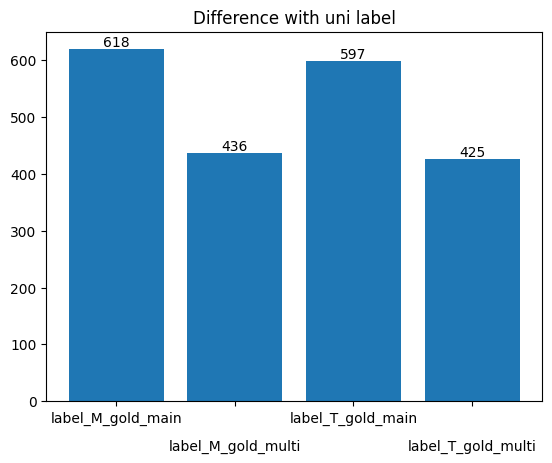

In [22]:
count_dict = {}
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if row["uni_label"] not in row[column]:
            count += 1
    count_dict[column] = count

fig, ax = plt.subplots()

bars = ax.bar(count_dict.keys(), count_dict.values())
ax.bar_label(bars, count_dict.values())
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.075)
ax.set_title("Difference with uni label")
plt.show()
plt.close()

For the "multi_label" the comparison is slightly more involved, as it is a list instead of a single element. A rough way to do it is by checking if said list is disjoint with the gold label.<br>

Compared to the "uni_label" these silver labels have slightly better results, but this is partially because of the way the comparison is done, as even a single emotion being in both labels counts as a positive example. Thus, results are still quite bad in this case as well.

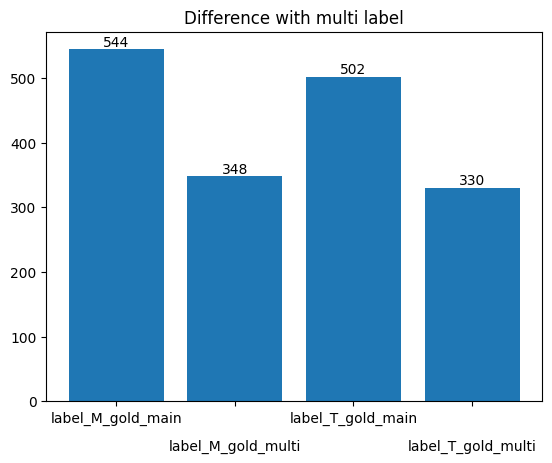

In [23]:
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if set(row["multi_label"]).isdisjoint(row[column]):
            count += 1
    count_dict[column] = count

fig, ax = plt.subplots()

bars = ax.bar(count_dict.keys(), count_dict.values())
ax.bar_label(bars, count_dict.values())
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.075)
ax.set_title("Difference with multi label")
plt.show()
plt.close()

## Difference between text only and multimodal labels

An interesting comparison is between the multimodal and text only gold labels, as it allows us to get an early look at how much the perception of emotions changes when one or more images are added to the context as opposed to classification done only on text. As before, one way to do this comparison is by checking if the sets are disjoint.<br>

Results differ quite a bit between the two types of gold label (depending on selection method, score higher than 1 or higher than 2). When considering a score higher than 2, thus a more selective gold label, 214 samples have completely disjoint gold labels, suggesting that images can, rather expectedly, make a difference to how the text is perceived by a reader.<br>

With the less restrictive gold labels there is more overlap, which is to be expected simply because of the labels containing more emotions overall and the comparison checking only if they share at least one element.<br>

One way to further analyze this topic might be checking how much the labels acrually overlap between each other instead of checking only if there is any overlap at all.

In [24]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_main"]).isdisjoint(row["label_T_gold_main"]):
        count += 1
print(count)

214


In [25]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_multi"]).isdisjoint(row["label_T_gold_multi"]):
        count += 1
print(count)

28


## Correlation between label scores

The correlation matrix is about what one might expect in this case.<br>

Correlation tends to be high when comparing the text only and multimodal scores of the same emotion. A notable exception to this is for the label "something else". The two labels have a correlation of 0.22, which, while positive, is lower than for the other labels. This might be caused by the fact that what is considered "something else" changes based on the presence or lack of images.<br>

The correlation between different emotions is also not particularly surprising. In general positive emotions correalate positively among themselves and negative emotions do so as well, albeit more strongly than positive ones. Positive and negative emotions have negative correlation with each other too. Neutral and "something else" are also inversely correlated with every other label.

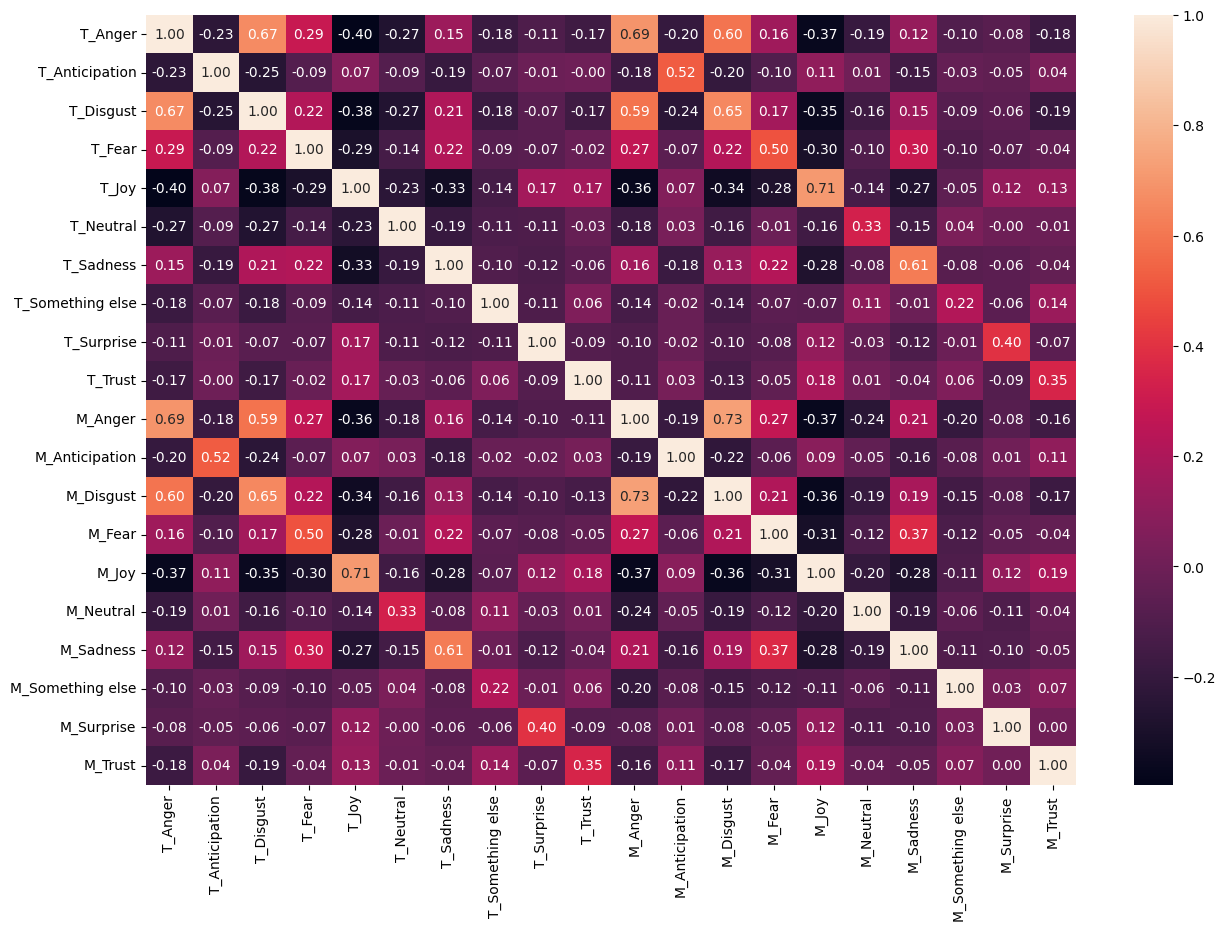

In [26]:
import seaborn as sns

cols = df.columns[df.columns.str.startswith("T_")].tolist() + df.columns[df.columns.str.startswith("M_")].tolist()
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df[cols].corr(), annot = True, fmt = '.2f')
plt.show()
plt.close()

## Top images for each emotion

The top 10 images for each emotion are plotted here, together with the corresponding tweets.<br>

In [27]:
import ipyplot

In [28]:
tweets = []
images = []
labels = []
for e in emotions:
    label = f"M_{e.capitalize()}"
    for i, row in df.sort_values(label, ascending=False).head(10).iterrows():
        tweets.append(row["tweet"])
        images.append(f"dataset/gold_images/twint_images3/{row['id']}_0.jpg")
        labels.append(label)

ipyplot.plot_class_tabs(images, labels, custom_texts=tweets, show_url=False, img_width=150)

In [29]:
tweets = []
images = []
labels = []
for e in emotions:
    label = f"T_{e.capitalize()}"
    for i, row in df.sort_values(label, ascending=False).head(10).iterrows():
        tweets.append(f"{i} " + row["tweet"])
        images.append(f"dataset/gold_images/twint_images3/{row['id']}_0.jpg")
        labels.append(label)

ipyplot.plot_class_tabs(images, labels, custom_texts=tweets, show_url=False, img_width=150)

## Wordclouds

In [30]:
from collections import Counter
from wordcloud import WordCloud
import re

In [31]:
# function to plot wordclouds

# df is the dataset to use to plot the wordcloud
# multimodal is a flag to know which labels to use
# threshold is the minimum score to have in labels to be included in the wordcloud
def plot_wordcloud(df:pd.DataFrame, multimodal:bool, threshold:float = 0):
    fig, axs = plt.subplots(2, 5, figsize=(25, 10))

    if multimodal:
        label_type = "M"
    else:
        label_type = "T"

    for e, ax in zip(emotions, axs.flat):
        label = f"{label_type}_{e.capitalize()}"
        combined_text = ' '.join(df.loc[df[label] > threshold]['tweet'])

        pattern = re.compile("&amp")
        combined_text = re.sub(pattern, "", combined_text)

        # cleaning the tweet text, code inspired from https://medium.com/codex/making-wordcloud-of-tweets-using-python-ca114b7a4ef4
        
        # remove emoji
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030"
            "]+", flags=re.UNICODE)
        combined_text = re.sub(emoji_pattern,'',combined_text)

        # remove urls
        url_pattern = re.compile(r'https?://\S+|www\.\S+?')
        combined_text = re.sub(url_pattern,'', combined_text)

        # remove @ mentions and hashes
        hash_pattern = re.compile("#")
        combined_text = re.sub(hash_pattern,"",combined_text)

        mention_pattern = re.compile("@[A-Za-z0–9_]+")
        combined_text = re.sub(mention_pattern,"",combined_text)
        
        # remove occurrences of &amp;
        and_pattern = re.compile("&amp;")
        combined_text = re.sub(and_pattern,"&",combined_text)

        wordcloud = (
            WordCloud(max_font_size=50, 
                    max_words=100,       
                    background_color="white",
                    min_word_length=3,
                    width=400,
                    height=400)
            .generate(combined_text)
        )
        ax.set_title(e.capitalize(), fontsize=15)
        ax.imshow(wordcloud)
        ax.axis("off")

    if multimodal:
        plt.suptitle("Multimodal wordclouds", fontsize=30)
    else:
        plt.suptitle("Text only wordclouds", fontsize=30)
    plt.show()
    plt.close()

In the wordcloud for tweets labeled with "fear" there are less words than other wordclouds. A possible explanation is that there are less tweets with that label. The same does not happen for "trust" though, despite a similar number of samples. "anticipation" also has fewer words than other labels, but only slightly.

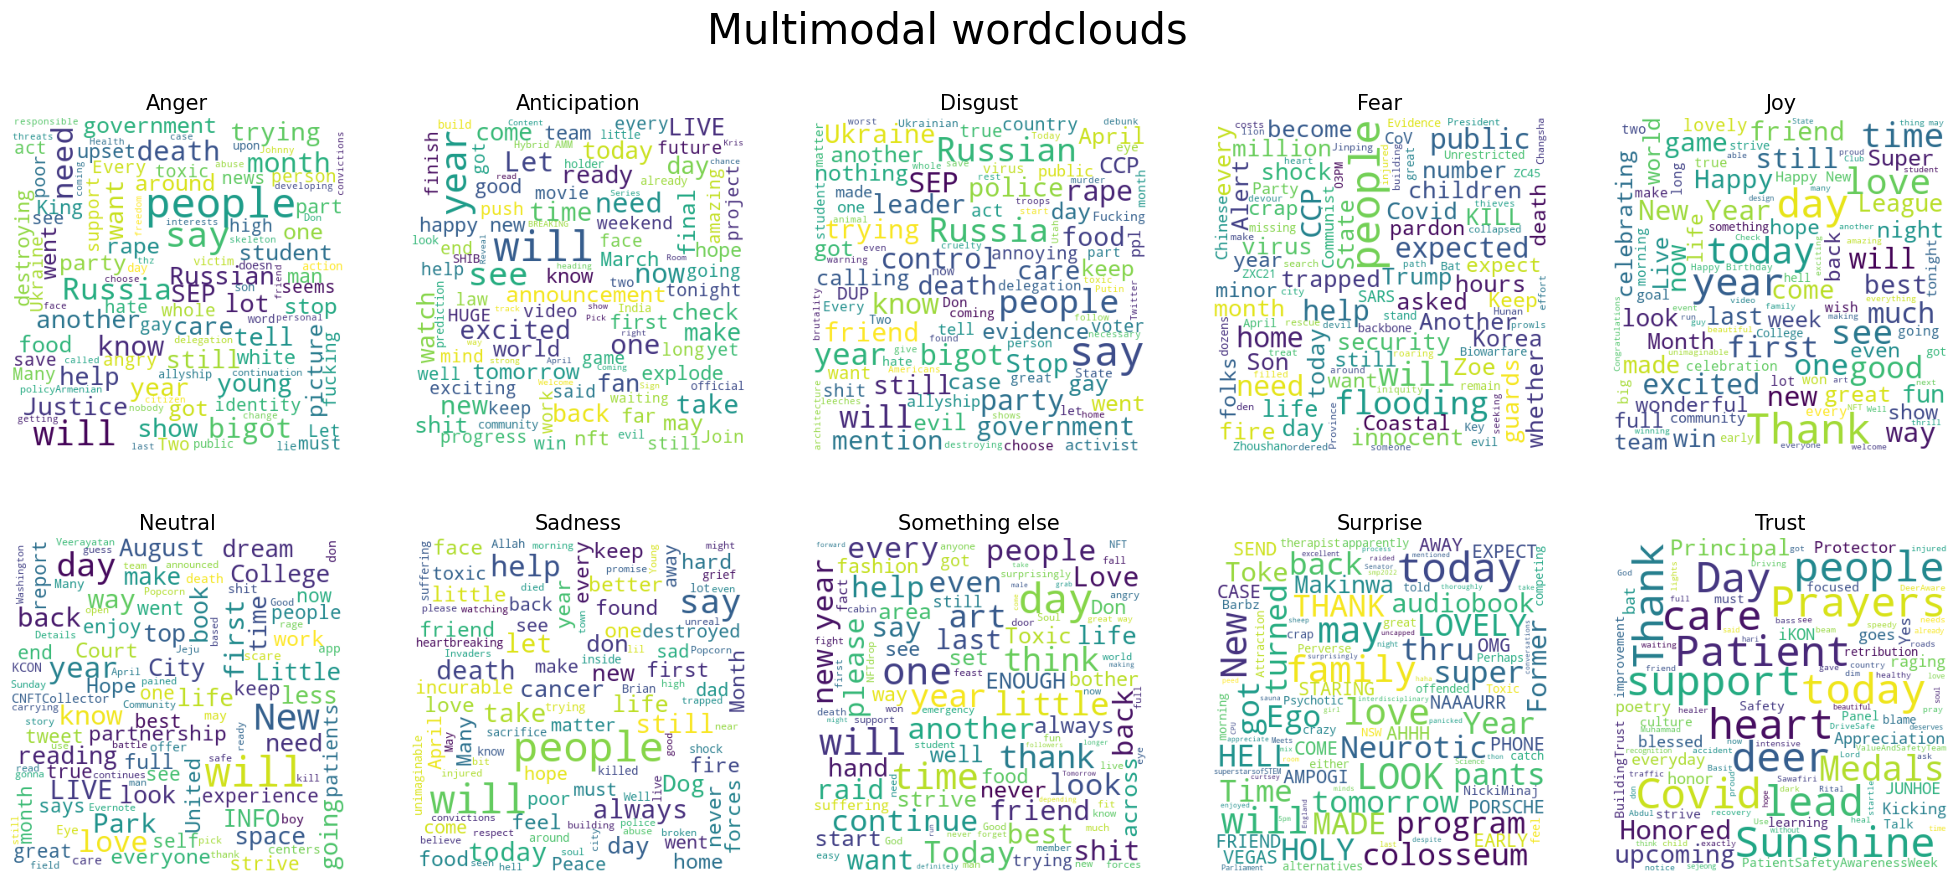

In [32]:
plot_wordcloud(df=df, multimodal=True, threshold=2)

Similar behaviour to multimodal, though "sadness" and "something else" also have sparse wordclouds. "fear" is less sparse compared to multimodal wordclouds.

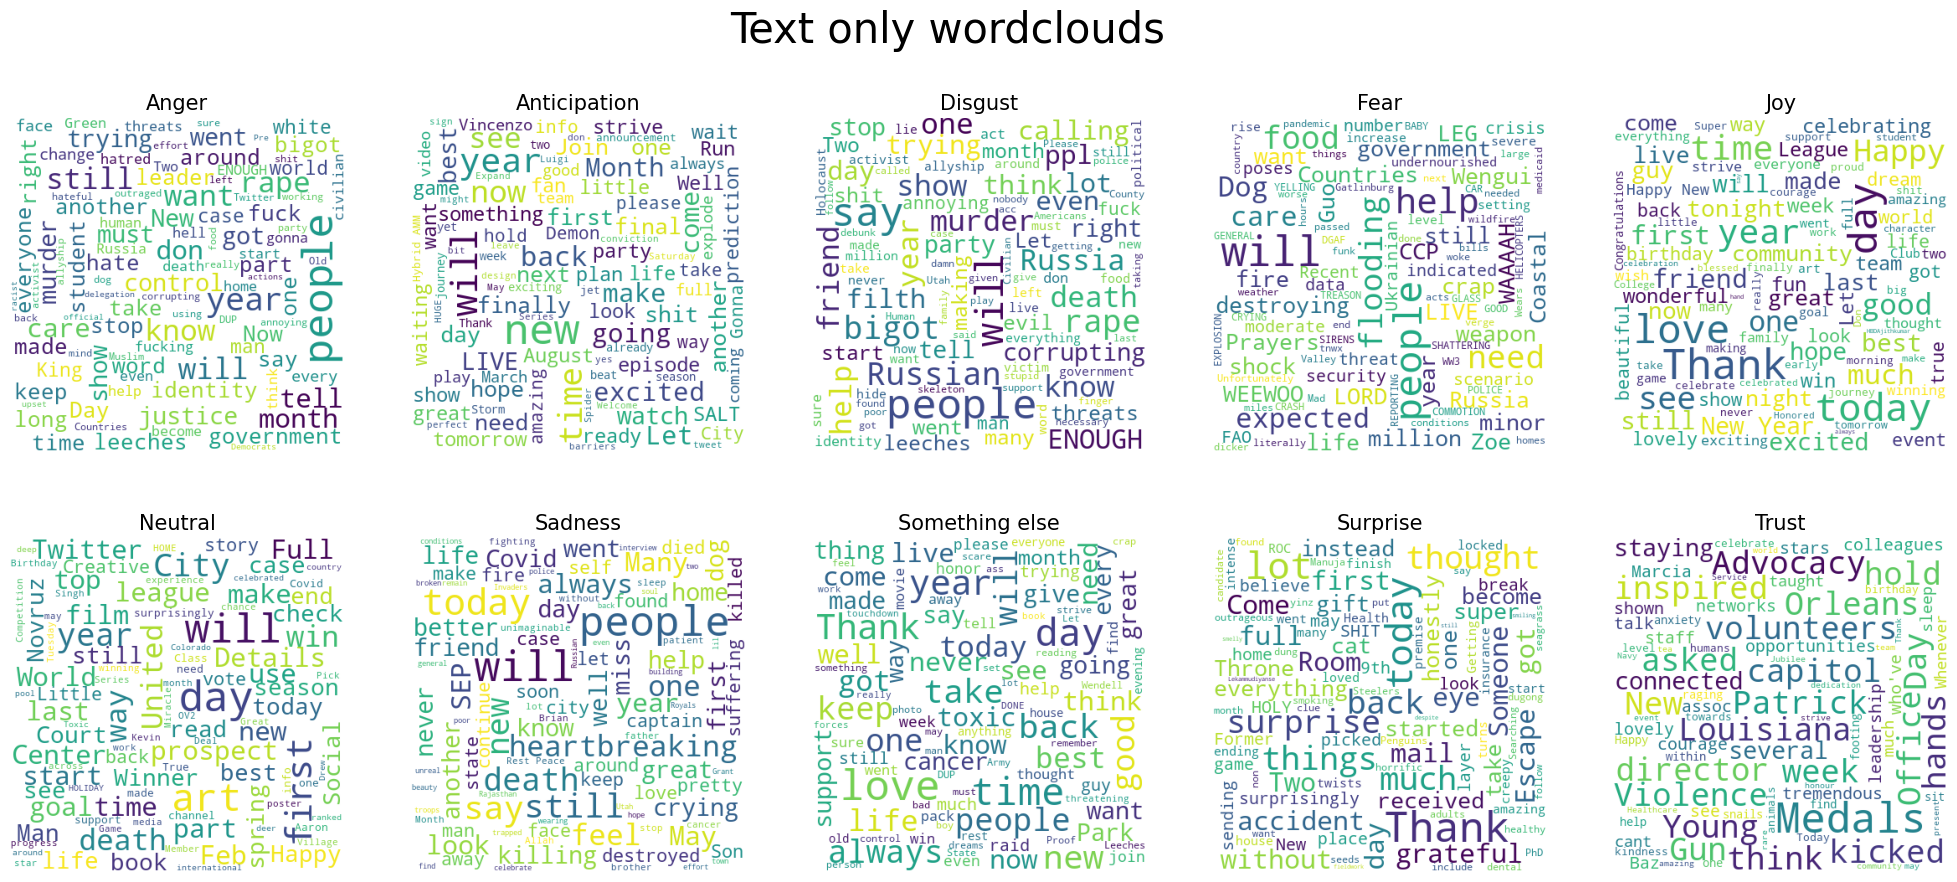

In [33]:
plot_wordcloud(df=df, multimodal=False, threshold=2)